# Изменение источников трафика и перераспределение бюджета в отделе маркетинговой аналитики Яндекс.Афиши

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.
Предстоит изучить:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.
Выручка измеряется в условных единицах — у.е.

На основе этих данных необходимо помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

##  Загрузка данных и подготовка их к анализу

- Положить данные о визитах, заказах и рекламных расходах в переменные;
- Подготовить данные. Убедиться, что тип данных во всех колонках соответствует сохранённым в них значениям.

In [1]:
#импортируем все необходимые нам библтотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
#читаем файлы и присваиваем переменные
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
datasets = pd.read_csv('/datasets/costs.csv')

In [3]:
#изучим каждый датасет подробно.
visits.sample(10)

,Device,End Ts,Source Id,Start Ts,Uid
222600,touch,2018-01-22 14:57:00,4,2018-01-22 14:56:00,11288320010151167853
64663,desktop,2018-01-30 16:33:00,1,2018-01-30 16:33:00,3343983125751660419
117645,touch,2018-04-21 03:05:00,4,2018-04-21 02:57:00,2561154739089435332
353664,touch,2018-05-16 17:43:00,2,2018-05-16 17:43:00,1818294516624254215
4155,touch,2017-09-08 21:16:00,4,2017-09-08 21:16:00,8971810343013819522
133525,touch,2017-07-18 17:01:00,5,2017-07-18 16:39:00,5648927539400666226
271855,touch,2017-07-04 21:07:00,4,2017-07-04 21:04:00,10784143643974486510
131090,desktop,2018-05-28 15:04:00,5,2018-05-28 14:40:00,12263813312527483227
188664,touch,2018-03-20 11:34:00,5,2018-03-20 11:13:00,15359371768014717358
36001,desktop,2018-01-15 14:32:00,2,2018-01-15 14:32:00,7884416087569019448


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
visits.describe()

,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


Есть несколько моментов, которые необходимо обработать:
- привести названия столбцов к общему регистру
- привести начало и конец сессии к формату datetime
- переименовать столбцы, заменив пробелы на нижнее подчеркивание


In [6]:
visits.columns = visits.columns.str.lower()

In [7]:
visits['end ts'] = pd.to_datetime(visits['end ts'])
visits['start ts'] = pd.to_datetime(visits['start ts'])

In [8]:
visits.set_axis(['device', 'end_ts','source_id','start_ts', 'uid'], axis="columns", inplace = True)

In [9]:
#Пропусков у нас нет изначально, проверим на дубли
visits.duplicated().sum()

0

In [10]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [11]:
#здесь все, переходим к следующему дф
orders.sample(10)

,Buy Ts,Revenue,Uid
25744,2017-12-24 14:48:00,5.19,5508352159380600858
29227,2018-01-13 14:20:00,2.44,17394970355805360534
14659,2017-10-26 11:19:00,1.95,12590971420513456932
11776,2017-10-09 13:27:00,2.08,11698879196152465479
47117,2018-05-13 07:48:00,2.20,9361724445442121929
24219,2017-12-15 12:42:00,14.67,10255413709144240332
10504,2017-10-04 10:18:00,0.61,836877350587901608
39852,2018-03-14 19:40:00,2.75,11001796634408650721
13780,2017-10-20 18:59:00,2.75,17570216184693434329
1923,2017-06-24 17:40:00,2.44,291701614935971619


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Также необходимо поменять названия без пробелов, с одним регистром и изменить тип данных на datetime

In [13]:
orders.set_axis(['buy_ts', 'revenue', 'uid'], axis="columns", inplace = True)

In [14]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [15]:
orders.duplicated().sum()

0

In [16]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [17]:
#посмотрим, что у нас в последнем дф
datasets.sample(10)

,source_id,dt,costs
2273,10,2017-09-03,10.13
1493,5,2017-07-12,103.19
2417,10,2018-01-25,37.58
1444,4,2018-05-24,288.83
562,2,2017-12-17,152.38
2502,10,2018-04-22,12.36
131,1,2017-10-10,56.04
1429,4,2018-05-09,133.48
2336,10,2017-11-05,18.70
2366,10,2017-12-05,34.68


In [18]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [19]:
#здесь нужно привести только дату к нужному формату
datasets['dt'] = pd.to_datetime(datasets['dt'])

In [20]:
datasets.duplicated().sum()

0

**Вывод**

При выгрузке данных обнаружили, что в целом достаточно качественные данные - нет пропусков, дубликатов. Для удобства заменила названия и привела все к одному регистру. Изменила формат даты, где было необходимо. Дубликатов и прочего мусора в данных нет. Можем переходить дальше

## Рассчет метрик и построение графиков

Посчитать метрики трёх видов:
- продуктовые,
- метрики электронной коммерции,
- маркетинговые.
Отобразить на графиках изменения каждой метрики во времени. Всякий раз подбирать наиболее подходящий тип визуализации: в некоторых случаях может быть уместна тепловая карта когортного анализа.
После каждого пункта сформулировать выводы.

**1.2.1. Продуктовые метрики**
- Рассчитайте DAU, WAU и MAU. Вычислите средние значения этих метрик за весь период;
- Определите, сколько раз за день пользователи в среднем заходят на сайт;
- Исследуйте, сколько времени пользователи проводят на сайте. Узнайте продолжительность типичной пользовательской сессии за весь период. Чтобы выбрать подходящую среднюю меру, постройте график распределения. Изменение продолжительности сессий во времени изучать необязательно;
- Рассчитайте Retention Rate, применяя когортный анализ. Найдите средний Retention Rate на второй месяц «жизни» когорт.

Для того, чтобы рассчитать DAU, WAU, MAU, нам необходимы данные id пользователя, время начала и окончания сессии. Для этого воспользуемся дф Visits.
Чтобы посчитать недельное и месячное использование, выделим в отдельные столбцы год, месяц и неделю, а также полную дату.

In [21]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

In [22]:
#Посчитаем метрики. Сгруппируем данные по уникальным пользователям и найдём среднее:
dau = int(visits.groupby('session_date').agg({'uid': 'nunique'}).mean())
wau = int(visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean())
mau = int(visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean())
dau, wau, mau

(907, 5716, 23228)

За день порядка 907 человек заходят проверить афишу, в месяц 5716, а в год порядка 23т человек

In [23]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [24]:
#найдем среднее количество сессий за день
session_count = visits.groupby('session_date')['uid'].count().mean()
session_count

987.3626373626373

Text(0.5, 1.0, 'Количество сессий за день')

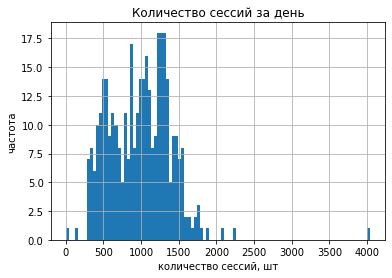

In [25]:
ax = visits.groupby('session_date')['uid'].count().hist(bins=100)
ax.set_xlabel('количество сессий, шт')
ax.set_ylabel('частота')
ax.set_title('Количество сессий за день')

В среднем мы имеем 987 пользователей. Но по динамике можно заметить, что есть пару выбивающихся дней с 4000 человек, но в целом мы имеет от 500 до 1500 человек.

Чтобы узнать среднюю продолжительность пользовательской сессии, посчитаем количество сессий и их типичную длину. Для этого построим гистограмму распределения продолжительности сессии:

Text(0.5, 1.0, 'распределение сессий по продолжительности')

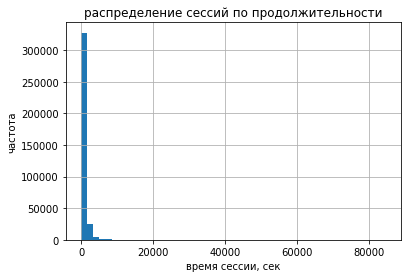

In [26]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
ax = visits['session_duration_sec'].hist(bins=50)
ax.set_xlabel('время сессии, сек')
ax.set_ylabel('частота')
ax.set_title('распределение сессий по продолжительности')


Длина сессий распределена неравномерно, рассчитаем моду (значение в выборке, которое встречается чаще всего):

In [27]:
visits['session_duration_sec'].mode()

0    60
dtype: int64

Типичная сессия длится всего одну минуту.

Рассчитаем Retention Rate -сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды. 


In [28]:
#найдем дату первого визита
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date,on='uid')


In [29]:
#найдем месяц начала активности для создания когорт
visits['first_visit_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]') 

In [30]:
#для каждой строки датафрейма рассчитаем lifetime пользователя в рамках когорты
visits['cohort_lifetime'] = visits['visit_month'] - visits['first_visit_month']
visits['cohort_lifetime'] =visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int') 

In [31]:
#Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей:
cohorts =visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 

In [32]:
#Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]

In [33]:
#Переименуем столбец uid в cohort_users
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

In [34]:
#Объединим данные по когортам с исходным количеством пользователей в когорте:
cohorts = cohorts.merge(initial_users_count,on='first_visit_month') 

In [35]:
#рассчитаем Retention Rate
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 


In [36]:
#Построим сводную таблицу и создадим тепловую карту:
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum') 


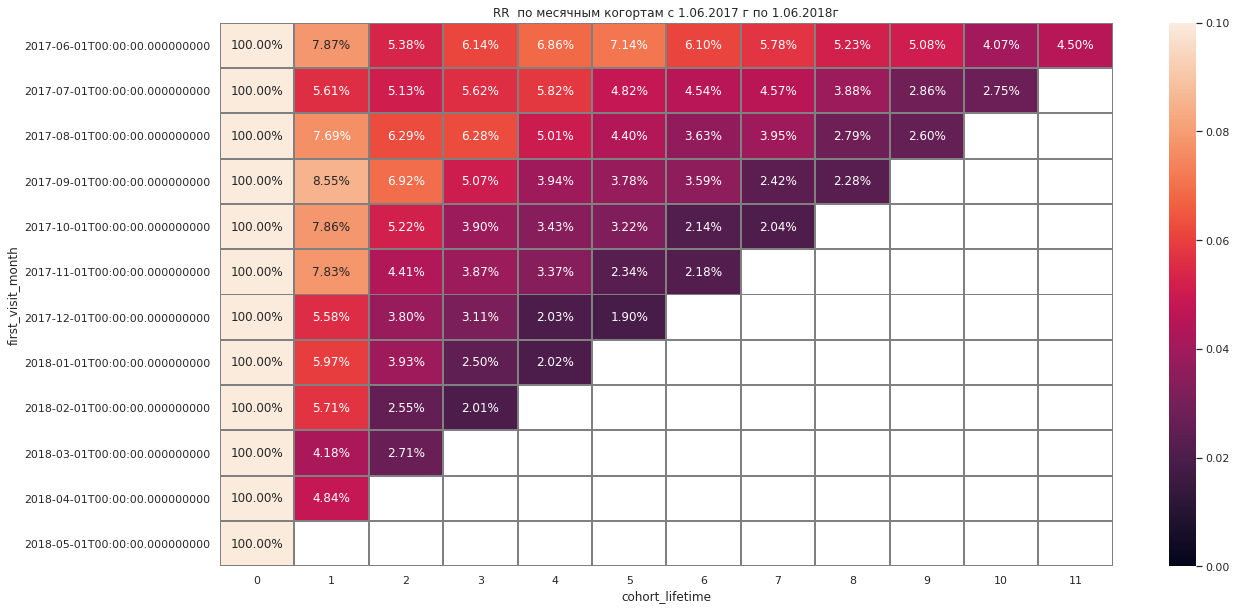

In [37]:
sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('RR  по месячным когортам с 1.06.2017 г по 1.06.2018г')
sns.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='gray', vmin = 0, vmax = 0.1)
plt.show()

In [38]:
r2=cohorts[cohorts['cohort_lifetime'] == 2]['retention'].mean() 
r2=r2*100
r2

4.63326221636773

Средний Retention Rate за второй месяц равен 4.63%


**вывод**

изучив продуктовые метрики, мы видим, что в среднем 900 человек заходят на сайт, при этом их сессия длится всего минуту. Retention Rate не стабилен по месяцам, но мы видим, что с большим отрывом январь- неверняка вляение каникул и выходных. На среднем уровне летние , отпускные месяца. Но основная масса с каждым разом становится все меньше, возможно, нет интересных событий на эти периоды.


**1.2.2. Метрики электронной коммерции**

- сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. Изучать изменение этой метрики во времени необязательно;
- Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. Изучать изменение этой метрики во времени необязательно;
- Рассчитайте средний чек;
- Выясните, как меняется во времени LTV на покупателя по когортам. Помните, что LTV — накопительная метрика. Рассчитайте средний LTV по когортам за 6 месяцев; в расчёт включайте когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%.

Для выявления времени от посещения до покупки, необходимо найти время первого посещения, время первой покупки и получить разницу между ними

In [39]:
first_activity_date = visits.groupby('uid')['start_ts'].min().reset_index()
first_buy_date = orders.groupby('uid')['buy_ts'].min().reset_index()
buy_date= first_activity_date.merge(first_buy_date, on ='uid')
buy_date['time_buy'] = (buy_date['buy_ts'] - buy_date['start_ts']).dt.seconds / 60


In [40]:
buy_date['time_buy'].mean()

249.1646907428196

Text(0.5, 1.0, 'время от первого визита до первой покупки')

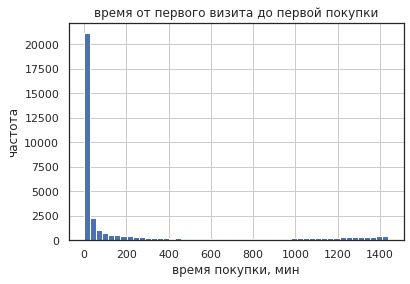

In [41]:
ax=buy_date['time_buy'].hist(bins=50)
ax.set_xlabel('время покупки, мин')
ax.set_ylabel('частота')
ax.set_title('время от первого визита до первой покупки')


Итого 249 минут проходит в среднем со времени первого посещения до покупки. При этом, распределяется неравномерно и мы видим моду в покупках с 0 значением. 

Найдем среднее количество покупок на одного покупателя за весь период

In [42]:
per_buy = orders.groupby('uid')['buy_ts'].count()
per_buy.mean()

1.3803630588943954

In [43]:
#найдем дату первой покупки
first_date = orders.groupby('uid')['buy_ts'].min()
first_date.name = 'first_date'
orders = orders.join(first_date,on='uid')


In [44]:
#найдем месяц начала активности для создания когорт
orders['first_visit_month'] = orders['first_date'].astype('datetime64[M]')
orders['visit_month'] = orders['buy_ts'].astype('datetime64[M]') 
orders

,buy_ts,revenue,uid,first_date,first_visit_month,visit_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01


In [45]:
#для каждой строки датафрейма рассчитаем lifetime пользователя в рамках когорты
orders['cohort_lifetime'] = orders['visit_month'] - orders['first_visit_month']
orders['cohort_lifetime'] =orders['cohort_lifetime'] / np.timedelta64(1,'M')
orders['cohort_lifetime'] = orders['cohort_lifetime'].round().astype('int') 


In [46]:
#Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество покупок:
cohorts =orders.groupby(['first_visit_month','cohort_lifetime']).agg({'revenue':'count', 'uid':'nunique'}).reset_index()
cohorts

,first_visit_month,cohort_lifetime,revenue,uid
0,2017-06-01,0,2354,2023
1,2017-06-01,1,177,61
2,2017-06-01,2,174,50
3,2017-06-01,3,226,54
4,2017-06-01,4,292,88
...,...,...,...,...
74,2018-03-01,2,176,58
75,2018-04-01,0,2495,2276
76,2018-04-01,1,195,69
77,2018-05-01,0,3249,2988


In [47]:
#Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]

In [48]:
#Переименуем столбец uid в cohort_users
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

In [49]:
#Объединим данные по когортам с исходным количеством пользователей в когорте:
cohorts = cohorts.merge(initial_users_count,on='first_visit_month') 

In [50]:
cohorts

,first_visit_month,cohort_lifetime,revenue,uid,cohort_users
0,2017-06-01,0,2354,2023,2023
1,2017-06-01,1,177,61,2023
2,2017-06-01,2,174,50,2023
3,2017-06-01,3,226,54,2023
4,2017-06-01,4,292,88,2023
...,...,...,...,...,...
74,2018-03-01,2,176,58,3533
75,2018-04-01,0,2495,2276,2276
76,2018-04-01,1,195,69,2276
77,2018-05-01,0,3249,2988,2988


In [51]:
cohorts['avg'] = cohorts['revenue']/cohorts['cohort_users']

In [52]:
cohorts

,first_visit_month,cohort_lifetime,revenue,uid,cohort_users,avg
0,2017-06-01,0,2354,2023,2023,1.163618
1,2017-06-01,1,177,61,2023,0.087494
2,2017-06-01,2,174,50,2023,0.086011
3,2017-06-01,3,226,54,2023,0.111715
4,2017-06-01,4,292,88,2023,0.144340
...,...,...,...,...,...,...
74,2018-03-01,2,176,58,3533,0.049816
75,2018-04-01,0,2495,2276,2276,1.096221
76,2018-04-01,1,195,69,2276,0.085677
77,2018-05-01,0,3249,2988,2988,1.087349


In [53]:
#Построим сводную таблицу и создадим тепловую карту:
buy_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='avg',aggfunc='sum') 
buy_pivot = buy_pivot.cumsum(axis=1)

In [54]:
buy_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.163618,1.251112,1.337123,1.448838,1.593178,1.700939,1.837370,1.923381,2.028176,2.103806,2.151261,2.193772
2017-07-01,1.136765,1.188768,1.251170,1.305252,1.342694,1.385335,1.417057,1.443058,1.473219,1.485699,1.513261,NaN
2017-08-01,1.118978,1.197810,1.270803,1.329927,1.391971,1.437226,1.472993,1.529927,1.563504,1.597080,NaN,NaN
2017-09-01,1.136381,1.221232,1.283611,1.347152,1.373111,1.415343,1.457187,1.478884,1.502518,NaN,NaN,NaN
2017-10-01,1.143779,1.216129,1.253456,1.281567,1.311290,1.335023,1.354839,1.383641,NaN,NaN,NaN,NaN
2017-11-01,1.179368,1.276648,1.321245,1.372948,1.406273,1.420730,1.445724,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.152635,1.214237,1.260324,1.301164,1.320785,1.344741,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.121554,1.187963,1.235102,1.254076,1.277201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.121611,1.182416,1.205149,1.224322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


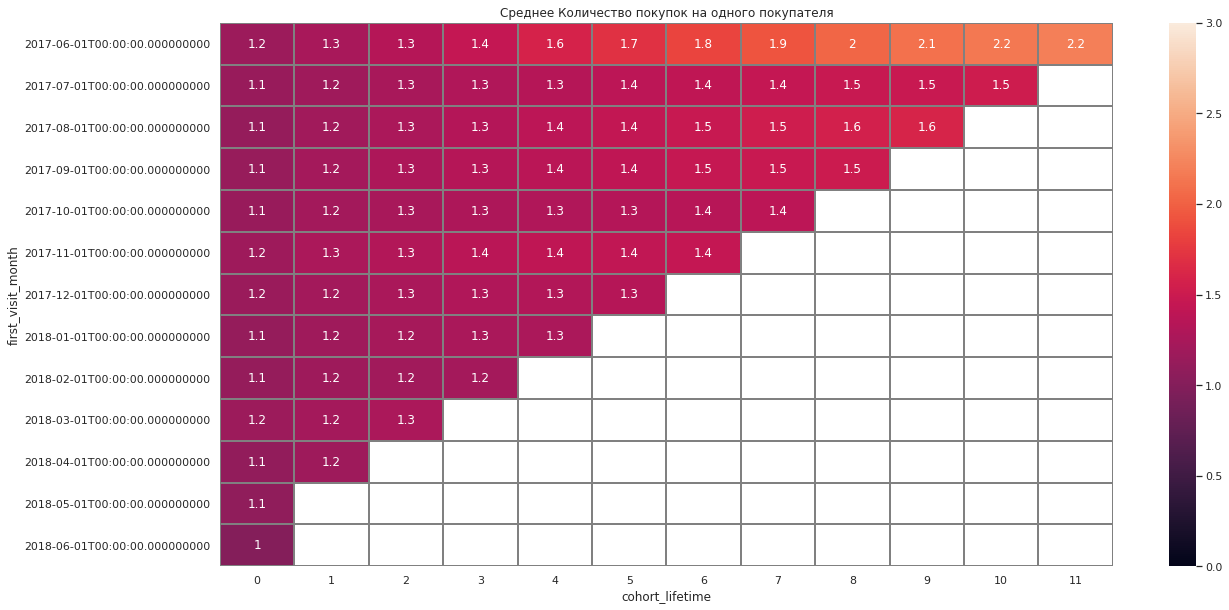

In [55]:
sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('Среднее Количество покупок на одного покупателя')
sns.heatmap(buy_pivot, annot=True, linewidths=1, linecolor='gray',vmin = 0, vmax = 3)
plt.show()

In [58]:
buy_pivot[6].mean()

1.4975282598152309

В среднем, на одного покупателя на 6 месяц жизни когорты 1?49 покупки

Рассчитаем средний чек. Для этого возьмем значения суммы покупок

In [58]:
orders['revenue'].mean()

4.999646930477041

LVT
Для начала найдем месяц покупки

In [59]:
#выделяем когорты, для этого нужен месяц
orders['month'] = orders['buy_ts'].astype('datetime64[M]')

In [60]:
#месяц первого заказа
first_orders =orders.groupby('uid').agg({'month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']


In [61]:
#сколько людей совершили покупку впервые в каждом месяце
cohort_sizes =first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [62]:
# Добавим месяц первой покупки каждого покупателя в таблицу с заказами
orders_new = pd.merge(orders,first_orders, on='uid')

In [63]:
#Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = orders_new.groupby(['first_order_month','month']).agg({'revenue': 'sum'}).reset_index()


In [64]:
#сколько людей первый раз совершили покупку в каждый месяц
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [65]:
report

,first_order_month,n_buyers,month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87
75,2018-04-01,2276,2018-04-01,10600.69
76,2018-04-01,2276,2018-05-01,1209.92
77,2018-05-01,2988,2018-05-01,13925.76


In [66]:
margin_rate = 1

In [67]:
#валовую прибыль,где в столбцах — не месяц заказа, а возраст (age) когорты
report['gp'] = report['revenue'] * margin_rate
report['age'] = ((report['month'] - report['first_order_month']) / np.timedelta64(1, 'M')).round()
report['age'] = report['age'].astype('int')
report['ltv'] = report['gp'] / report['n_buyers']


In [68]:
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='sum').round(2)
output = output.cumsum(axis=1)
    
output.fillna('') 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,
2017-12-01,4.74,5,5.93,7,7.31,7.65,,,,,,
2018-01-01,4.14,4.43,4.73,4.87,4.93,,,,,,,
2018-02-01,4.16,4.44,4.52,4.59,,,,,,,,


In [69]:
#посчитаем среднюю по всем когортам, старше 6 мес
output[6].mean()



8.385

В среднем каждый покупатель принес по 8.38  валовой прибыли за 6 месяцев «жизни».

**вывод**

Из анализа выявили, что на покупку в среднем уходит 4 часа, при этом на одного покупателя 1.3 совершенной покупки. Средний чек 5 у.е. Каждый покупатель в средднем принес 1.13 прибыли. Также можно заметить, что прибыль с каждым месяцем в основном значительно падает, выстреливают только июнь и сентябрь -  месяца отпусков

**1.2.3. Маркетинговые метрики**

Посчитайте и отобразите на графиках, как маркетинговые метрики различаются по рекламным источникам.
Один и тот же пользователь мог заходить на сайт из нескольких источников, поэтому важно определить «главный» источник для каждого и учитывать это в расчётах. Например, главным может стать первый источник перехода.

- Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам;
- Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика;
- Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт. Обратите внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV.

In [70]:
#посмотрим общие расходы
datasets['costs'].sum()

329131.62

In [71]:
#выгрузим, как делятся расходы по источникам
datasets.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Text(0.5, 1.0, 'Суммарные Расходы по источникам')

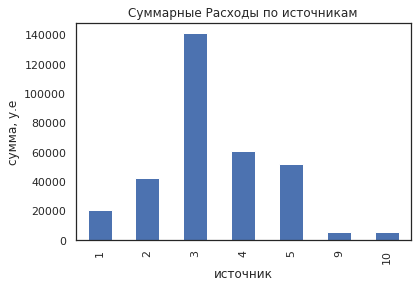

In [72]:
ax =datasets.groupby('source_id')['costs'].sum().plot(kind='bar')
ax.set_xlabel('источник')
ax.set_ylabel('сумма, у.е')
ax.set_title('Суммарные Расходы по источникам')


Третий источник лидирует по расходам и очень существенно из общей суммы в 329т 140т берет на себя именно он.

In [73]:
#посмотрим, как распределялись траты на каждый источник в течении времени
datasets['costs_month'] = datasets['dt'].astype('datetime64[M]')

Text(0.5, 1.0, 'расходы по каждому источнику во времени')

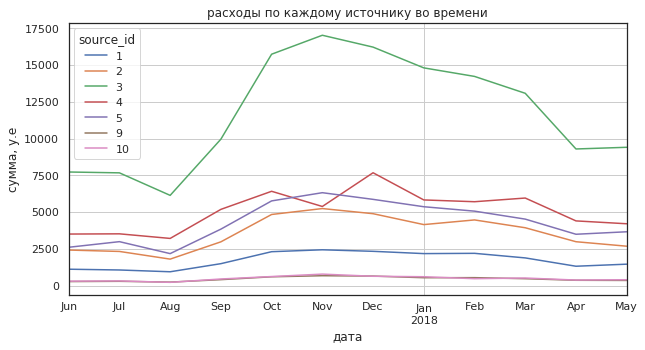

In [74]:
ax=datasets.pivot_table(index='costs_month', columns = 'source_id', \
                 values = 'costs', aggfunc ='sum').plot(figsize = (10,5), grid = True)
ax.set_xlabel('дата')
ax.set_ylabel('сумма, у.е')
ax.set_title('расходы по каждому источнику во времени')


В разрезе каждого источника, расзоды практически везде распределены равномерно во времени, если и есть выбивающиеся значения, как это в ноябре, декабре и январе. и основной упор, как мы видим, сделан и тут на источник 3.

**Считаем САС на одного покупателя**

In [75]:
#найдем сумму расходов за каждый месяц
monthly_costs = datasets.groupby('costs_month')['costs'].sum()


Text(0.5, 1.0, 'САС на одного покупателя')

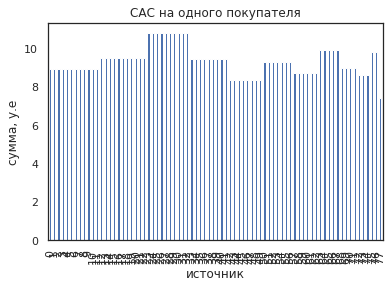

In [76]:
#Добавим информацию о расходах в когортный отчёт и посчитаем CAC каждой когорты
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='costs_month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
ax=report_new['cac'].plot(kind='bar')

ax.set_xlabel('источник')
ax.set_ylabel('сумма, у.е')
ax.set_title('САС на одного покупателя')

In [77]:
#Посчитаем CAC по источникам. 
cost_source_id = datasets.groupby('source_id').agg({'costs':'sum'}).rename({'costs':'costs'})
cost_source_id.reset_index()

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [78]:
visits_source = visits.query('start_ts == first_activity_date')
id_source = (orders.merge(visits_source, on='uid', how='inner')).groupby('source_id').agg({'uid':'nunique'}).rename(columns={'uid':'customer'})
id_source.reset_index()                     

,source_id,customer
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [79]:
source = id_source.join(cost_source_id)
source.reset_index()
source['cac'] = source['costs'] / source['customer']


Text(0.5, 1.0, 'САС по источникам')

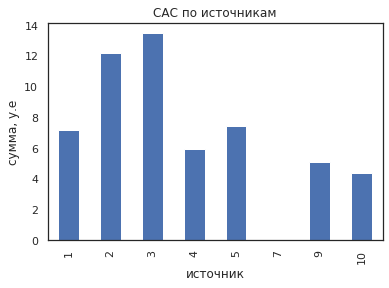

In [80]:
ax=source['cac'].plot(kind='bar')
ax.set_xlabel('источник')
ax.set_ylabel('сумма, у.е')
ax.set_title('САС по источникам')

**посчитаем ROMI когорт**

In [81]:
#таблица с затратами по источнику
cost_source_id = datasets.groupby('source_id').agg({'costs':'sum'}).rename({'costs':'costs'})
cost_source_id.reset_index()

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [82]:
#создаем таблицу с доходами по источникам
revenue =(orders.merge(visits_source, on='uid', how='inner')).groupby('source_id').agg({'revenue':'sum'}).rename(columns={'revenue':'revenue'})

In [83]:
#склеиваем доходы с расходами
cost =revenue.join(cost_source_id).reset_index()

In [84]:
#находим ROMI
cost['romi'] = cost['revenue'] / cost['costs']
cost

,source_id,revenue,costs,romi
0,1,31090.55,20833.27,1.492351
1,2,46923.61,42806.04,1.096191
2,3,54511.24,141321.63,0.385725
3,4,56696.83,61073.60,0.928336
4,5,52624.02,51757.10,1.016750
5,7,1.22,NaN,NaN
6,9,5759.40,5517.49,1.043844
7,10,4450.33,5822.49,0.764335


In [85]:
datasets.head()

,source_id,dt,costs,costs_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [86]:
#найдем дату первого расхода
first_date = datasets.groupby('source_id')['dt'].min()
first_date.name = 'first_date'
datasets = datasets.join(first_date,on='source_id')


In [87]:
#найдем месяц начала активности для создания когорт
datasets['first_visit_month'] = datasets['first_date'].astype('datetime64[M]')
datasets['visit_month'] = datasets['dt'].astype('datetime64[M]') 
datasets.head()

,source_id,dt,costs,costs_month,first_date,first_visit_month,visit_month
0,1,2017-06-01,75.20,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,1,2017-06-02,62.25,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,1,2017-06-03,36.53,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,1,2017-06-04,55.00,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,1,2017-06-05,57.08,2017-06-01,2017-06-01,2017-06-01,2017-06-01


In [88]:
#для каждой строки датафрейма рассчитаем lifetime пользователя в рамках когорты
datasets['cohort_lifetime'] = datasets['visit_month'] - datasets['first_visit_month']
datasets['cohort_lifetime'] =datasets['cohort_lifetime'] / np.timedelta64(1,'M')
datasets['cohort_lifetime'] = datasets['cohort_lifetime'].round().astype('int') 

In [89]:
#Сгруппируем данные по источнику и lifetime. Посчитаем для каждой когорты количество затрат:
cohorts =datasets.groupby(['source_id','cohort_lifetime']).agg({'costs':'sum'}).reset_index()
cohorts

,source_id,cohort_lifetime,costs
0,1,0,1125.61
1,1,1,1072.88
2,1,2,951.81
3,1,3,1502.01
4,1,4,2315.75
...,...,...,...
79,10,7,614.35
80,10,8,480.88
81,10,9,526.41
82,10,10,388.25


In [90]:
#найдем накопительное количесво затрат по когортам
output = cohorts.pivot_table(
        index='source_id', 
        columns='cohort_lifetime', 
        values='costs', 
        aggfunc='mean').round()
output = output.cumsum(axis=1)
output

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,1126.0,2199.0,3151.0,4653.0,6969.0,9414.0,11755.0,13941.0,16145.0,18038.0,19365.0,20833.0
2,2427.0,4760.0,6571.0,9557.0,14402.0,19650.0,24548.0,28706.0,33180.0,37123.0,40117.0,42806.0
3,7732.0,15406.0,21550.0,31514.0,47251.0,64276.0,80496.0,95305.0,109534.0,122615.0,131912.0,141323.0
4,3515.0,7045.0,10262.0,15454.0,21875.0,27264.0,34944.0,40777.0,46489.0,52451.0,56859.0,61073.0
5,2616.0,5614.0,7799.0,11648.0,17415.0,23740.0,29613.0,34985.0,40056.0,44586.0,48087.0,51757.0
9,285.0,588.0,837.0,1253.0,1862.0,2545.0,3203.0,3750.0,4302.0,4782.0,5155.0,5517.0
10,314.0,644.0,877.0,1338.0,1965.0,2757.0,3403.0,4017.0,4498.0,5024.0,5412.0,5822.0


In [91]:
ds =orders.merge(visits_source, on='uid', how='inner')


In [92]:
#Сгруппируем данные по источнику и lifetime. Посчитаем для каждой когорты доходы:
cohorts2 =ds.groupby(['source_id','cohort_lifetime_x']).agg({'revenue':'sum'}).reset_index()
cohorts2

,source_id,cohort_lifetime_x,revenue
0,1,0,18103.37
1,1,1,2671.98
2,1,2,2282.85
3,1,3,2110.42
4,1,4,1172.91
...,...,...,...
77,10,5,13.29
78,10,6,11.18
79,10,7,16.30
80,10,8,3.36


In [93]:
#найдем накопительное количесво затрат по когортам
output2 = cohorts2.pivot_table(
        index='source_id', 
        columns='cohort_lifetime_x', 
        values='revenue', 
        aggfunc='mean').round()
output2 = output2.cumsum(axis=1)
output2   

cohort_lifetime_x,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,18103.0,20775.0,23058.0,25168.0,26341.0,27074.0,27821.0,28883.0,29834.0,30396.0,30773.0,31090.0
2,23178.0,28150.0,33782.0,39437.0,41894.0,43757.0,45041.0,45733.0,46196.0,46426.0,46821.0,46923.0
3,47009.0,49835.0,51355.0,52388.0,53132.0,53630.0,53913.0,54173.0,54369.0,54444.0,54490.0,54511.0
4,46901.0,48825.0,49810.0,51165.0,52201.0,53336.0,55110.0,55526.0,55722.0,56127.0,56662.0,56697.0
5,33552.0,35301.0,36727.0,47128.0,48502.0,50191.0,51065.0,51663.0,52015.0,52487.0,52579.0,52624.0
7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4235.0,4542.0,4844.0,5086.0,5242.0,5381.0,5499.0,5588.0,5731.0,5750.0,5759.0,NaN
10,4205.0,4291.0,4327.0,4378.0,4402.0,4415.0,4426.0,4442.0,4445.0,4448.0,NaN,NaN


In [94]:
#итоговый накопительный ROMI
output3 = output2/output

In [95]:
output3

cohort_lifetime_x,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,16.077265,9.447476,7.317677,5.408983,3.779739,2.875929,2.366738,2.071803,1.847879,1.685109,1.589104,1.492344
2,9.550062,5.913866,5.141074,4.126504,2.908902,2.226819,1.834813,1.593151,1.392285,1.250599,1.167111,1.096178
3,6.079798,3.234779,2.383063,1.662372,1.124463,0.834371,0.669760,0.568417,0.496366,0.444024,0.413078,0.385719
4,13.343101,6.930447,4.853830,3.310793,2.386331,1.956279,1.577095,1.361699,1.198606,1.070084,0.996535,0.928348
5,12.825688,6.288030,4.709193,4.046016,2.785070,2.114195,1.724412,1.476719,1.298557,1.177208,1.093414,1.016751
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,14.859649,7.724490,5.787336,4.059058,2.815252,2.114342,1.716828,1.490133,1.332171,1.202426,1.117168,NaN
10,13.391720,6.663043,4.933865,3.272048,2.240204,1.601378,1.300617,1.105800,0.988217,0.885350,NaN,NaN


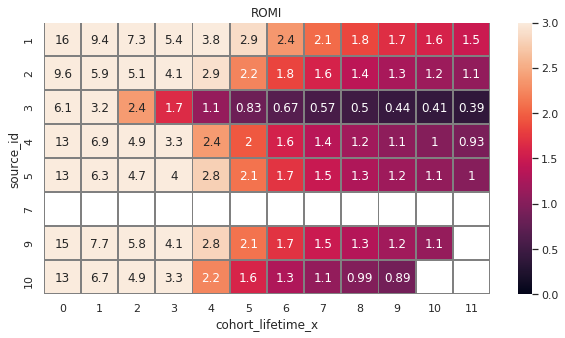

In [96]:
sns.set(style='white')
plt.figure(figsize=(10, 5))
plt.title('ROMI')
sns.heatmap(output3, annot=True, linewidths=1, linecolor='gray',vmin = 0, vmax = 3)
plt.show()

**вывод**

Самые большие расходы мы имеет на третий источник, при этом расходы на маркетинг по пользователям примерно рдинаковый. Оправдывает себя источники номер 1 и 2. Истоник 7 - выбивается. Не имеет никаких показателей.

## Общий вывод

Отличные источники 1 и 2 - они полностью себя окупили и, более того, имеют хорошие показатели в течении всех когорт.Также, в сравнении с другими источниками, имеют относительно небольшие затраты. Источник 3 неплохо окупал себя в начале, но показывает отрицательную динамику с каждой когортой. При этом затраты максимальные и вложения в этот источник продолжают идти. Стоит обратить внимание. 4 и 5, 8, 9 источники, в целом, итогово окупаемы, но динамика отрицательная.7 источник не имеет данных, возможно, это была какая то единичная реклама. 
Retention Rate не стабилен по месяцам, но мы видим, что с большим отрывом январь- неверняка вляение каникул и выходных. В среднем в день имеем около 1000 пользователей, однако сессия в своей моде составяет 1 минуту - тут либо баг сайта, либо есть какие-то трудности . В среднем, LTV 6 у.е. на покупателя на 6 месяцев «жизни», при этом 2 покупки.
По большей части это одноразовые входы, так как с каждым месяцем когорты посещения отваливаются. На покупку уходит около 4 часов - возможно, заказ лежит долго в корзине. Либо есть трудности с оформлением, проверка билетов и т.д.
